In [66]:
import s3fs
import pyarrow.parquet as pq
import pyarrow as pa
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import numpy as np

In [155]:
plt.style.use('ggplot')

In [4]:
fs = s3fs.S3FileSystem(
    client_kwargs={
        "endpoint_url": "https://minio.minio-tenant",
        "aws_access_key_id": "admin",
        "aws_secret_access_key": "6bd71ace-8866-407a-9bcc-714bc5753f18",
        "verify": "/home/rafael/.certs/dev/rootCA.pem",
    }
)

In [165]:
# select preciptation data from Minas Gerais state

filters = [('adm1', '=', 'BRA.13_1'), ('element', '=', 'PRCP')]
pa_prcp = pq.read_table("dutrajardim-fi/tables/ghcn.parquet", filters=filters, filesystem=fs)
pd_prcp = pa_prcp.to_pandas()
pd_prcp['date'] = pd_prcp['datetime'].dt.strftime('%Y-%m-%d')
pd_prcp['month_week'] = pd_prcp['datetime'].dt.strftime('%m-%W')

In [6]:
filters = [('adm1', '=', 'BRA.13_1')]
pa_ghcn = pq.read_table("dutrajardim-fi/tables/ghcn.parquet", filters=filters, filesystem=fs)
pd_ghcn = pa_ghcn.to_pandas()

In [7]:
# select stations next to Minas Gerais' administrative areas level 3 (data duplication on adms level 2, 1 and 0)

# filters = [('adm1', '=', 'BRA.13_1'), ('distance', '<', 40000)]
filters = [('adm1', '=', 'BRA.13_1')]
pa_stations = pq.read_table("dutrajardim-fi/tables/stations.parquet", filters=filters, filesystem=fs, columns=['geometry', 'id', 'adm2', 'adm3'])
pd_stations = pa_stations.to_pandas()
pd_stations = pd_stations.groupby('id').first().reset_index()

In [8]:
# select adminstrative areas level 2 from Minas Gerais

filters = [('adm1', '=', 'BRA.13_1')]
pa_shapes2 = pa.parquet.read_table("dutrajardim-fi/tables/shapes/adm2.parquet", filters=filters, filesystem=fs)
pd_shapes2 = pa_shapes2.to_pandas()

In [9]:
# select admistrative areas level 3 from Minas Gerais

filters = [('adm1', '=', 'BRA.13_1')]
pa_shapes3 = pa.parquet.read_table("dutrajardim-fi/tables/shapes/adm3.parquet", filters=filters, filesystem=fs)
pd_shapes3 = pa_shapes3.to_pandas()

In [10]:
gpd_shapes2 = gp.GeoDataFrame(
    pd_shapes2[["id", "name"]],
    geometry=gp.GeoSeries.from_wkt(pd_shapes2['geometry']),
    crs=4326
)
gpd_shapes2 = gpd_shapes2.to_crs(3857)

gpd_shapes3 = gp.GeoDataFrame(
    pd_shapes3[["id", "name"]],
    geometry=gp.GeoSeries.from_wkt(pd_shapes3['geometry']),
    crs=4326
)
gpd_shapes3 = gpd_shapes3.to_crs(3857)

gpd_stations = gp.GeoDataFrame(
    pd_stations[['id', 'adm2', 'adm3']],
    geometry=gp.GeoSeries.from_wkt(pd_stations['geometry']),
    crs=3857
)

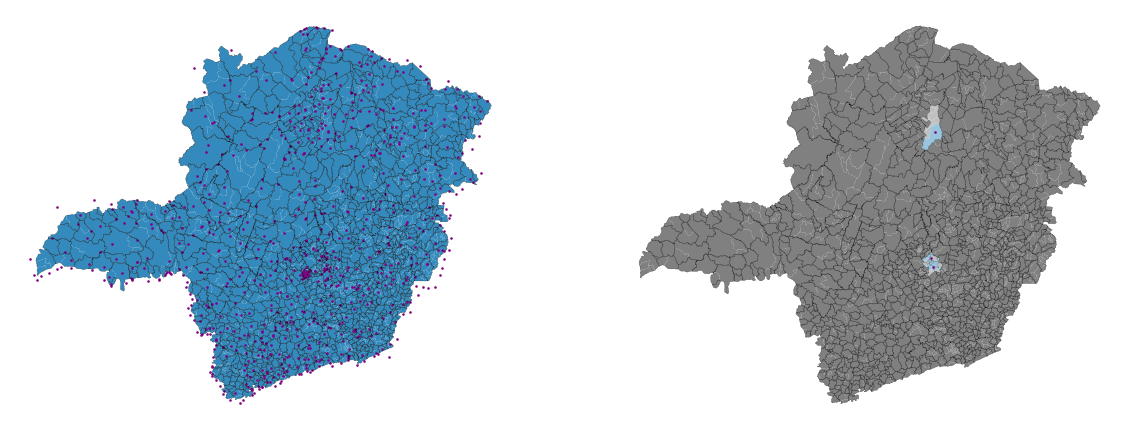

In [156]:
nrows, ncols = 1, 2

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,10))

adm3_covered = pa_stations.to_pandas()['adm3'].unique()

gpd_shapes3[gpd_shapes3['id'].isin(adm3_covered)].plot(ax=axs[0])
# gpd_shapes3[~gpd_shapes3['id'].isin(adm3_covered)].plot(ax=axs[0], color='#ccc')
gpd_stations.plot(ax=axs[0], color='purple', markersize=4)

gpd_shapes2.plot(ax=axs[0], edgecolor='black', linewidth=.2, facecolor='none')


# chart 2
amd2_covered = pa_stations.to_pandas()['adm2'].unique()
gpd_shapes3[~gpd_shapes3['id'].isin(pd_prcp['adm3'].unique())].plot(ax=axs[1], color='gray')
gpd_shapes3[gpd_shapes3['id'].isin(pd_prcp['adm3'].unique())].plot(ax=axs[1])
gpd_shapes2[~gpd_shapes2['id'].isin(pd_prcp['adm2'].unique())].plot(ax=axs[1], edgecolor='black', linewidth=.2, facecolor='none')
gpd_shapes2[gpd_shapes2['id'].isin(pd_prcp['adm2'].unique())].plot(ax=axs[1], edgecolor='black', linewidth=.2, facecolor='white', alpha=.5)

gpd_stations[gpd_stations['id'].isin(pd_prcp['station'].unique())].plot(ax=axs[1], color='purple', markersize=4)

for i in range(nrows * ncols):
    axs[i].set_axis_off()

plt.show()

In [48]:
pd_prcp['adm2'].unique()

array(['BRA.13.680_1', 'BRA.13.662_1', 'BRA.13.65_1', 'BRA.13.640_1',
       'BRA.13.504_1', 'BRA.13.580_1', 'BRA.13.743_1', 'BRA.13.199_1',
       'BRA.13.845_1', 'BRA.13.433_1'], dtype=object)

In [16]:
pd_shapes2[pd_shapes2['id'].isin(pd_prcp['adm2'].unique())][['id', 'name']].set_index('id')

,name
id,
BRA.13.65_1,Belo Horizonte
BRA.13.199_1,Confins
BRA.13.433_1,Lagoa Santa
BRA.13.504_1,Montes Claros
BRA.13.580_1,Pedro Leopoldo
BRA.13.640_1,Ribeirão das Neves
BRA.13.662_1,Sabará
BRA.13.680_1,Santa Luzia
BRA.13.743_1,São José da Lapa


In [83]:
pd_prcp.columns

Index(['station', 'value', 'measurement_flag', 'quality_flag', 'source_flag',
       'datetime', 'adm2', 'adm3', 'element', 'adm0', 'adm1', 'year', 'date',
       'week'],
      dtype='object')

In [169]:
pdgrp_prcp = pd_prcp \
    .sort_values(by='datetime') \
    .groupby(['adm2', 'year', 'month_week']).agg(
        datetime=pd.NamedAgg('datetime', 'last'),
        number_of_stations=pd.NamedAgg('station', 'nunique'),
        # mean_value=pd.NamedAgg('value', 'mean'),
        mean_value=pd.NamedAgg('value', lambda x: x.sum() / 7),
        sum_value=pd.NamedAgg('value', 'sum'),
        days_of_data=pd.NamedAgg('date', 'count')
    )

pdgrp_prcp

datetime  number_of_stations  \
adm2         year month_week                                           
BRA.13.199_1 2018 01-00                      NaT                   0   
                  01-01                      NaT                   0   
                  01-02                      NaT                   0   
                  01-03                      NaT                   0   
                  01-04                      NaT                   0   
...                                          ...                 ...   
BRA.13.845_1 2021 12-49      2021-12-10 03:00:00                   1   
                  12-50      2021-12-19 03:00:00                   1   
                  12-51      2021-12-26 03:00:00                   1   
                  12-52      2021-12-31 03:00:00                   1   
                  12-53                      NaT                   0   

                              mean_value  sum_value  days_of_data  
adm2         year month_week                                       
BRA.13.199_1 2018 01-00              NaN          0             0  
                  01-01              NaN          0             0  
                  01-02              NaN          0             0  
                  01-03              NaN          0             0  
                  01-04              NaN          0             0  
...                                  ...        ...           ...  
BRA.13.845_1 2021 12-49       163.000000       1141             5  
                  12-50       111.428571        780             7  
                  12-51        27.285714        191             3  
                  12-52       153.142857       1072             5  
                  12-53              NaN          0             0  

[2920 rows x 5 columns]

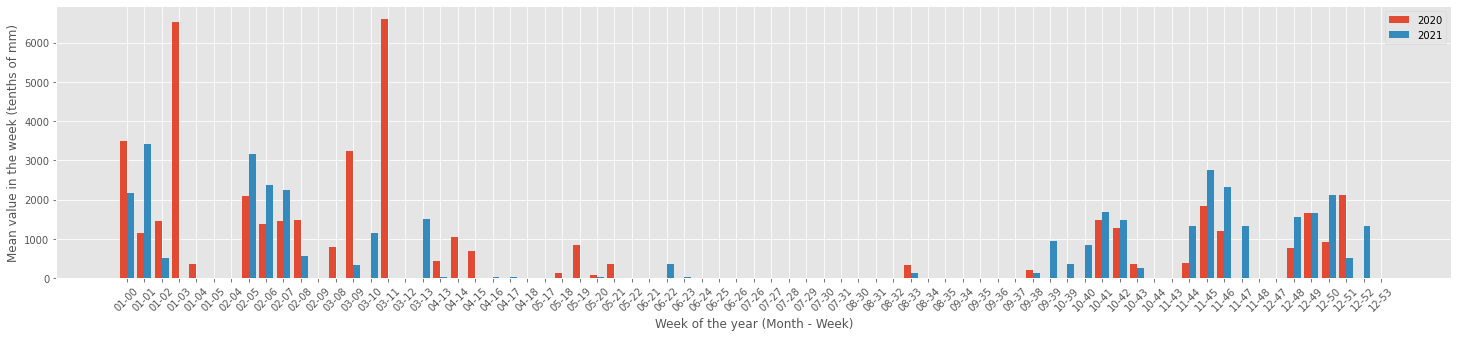

In [170]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(25, 5))
years = [2020, 2021]
number_of_bars = len(years)
width = .4

xticks = []
data_x_labels = []

for key, year in enumerate(years):

    data_df = pdgrp_prcp.loc[('BRA.13.65_1', year), 'mean_value']
    if key == 0:
        data_x_labels = data_df.index
        xticks = np.arange(len(data_x_labels))
    
    data_x = xticks + width * (key % number_of_bars)
    data_y = data_df.values

    axs.bar(data_x, data_y, width=width, label=year)

axs.set_xticks(xticks + width / (2 / 2 ** (number_of_bars - 2)))
axs.set_xticklabels(data_x_labels)
axs.xaxis.set_tick_params(rotation=45)
axs.legend()
axs.set_ylabel('Mean value in the week (tenths of mm)')
axs.set_xlabel('Week of the year (Month - Week)')

plt.show()